In [1]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data
#Define Directories for train, test & Validation Set
train_path = 'dataset/train'
valid_path = 'dataset/val'
test_path = 'dataset/test'
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 8
#The dimension of the images we are going to define is 500x500 
img_height = 224
img_width = 224
#The dimension size of 500 or more than 500 with batch size greater than 16 may result in a crash as the RAM gets completely used in such cases. A lower dimension size with greater batch size is one of the options to try.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [4]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train'

[0. 0. 1. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 1. 1. 0.]
[1. 0. 0. 1. 0. 0. 1. 0.]
[1. 0. 0. 0. 1. 1. 1. 0.]
[1. 1. 1. 0. 0. 0. 1. 1.]
[1. 1. 0. 1. 1. 0. 1. 0.]
[1. 1. 0. 0. 1. 1. 1. 1.]
[0. 0. 0. 1. 0. 1. 1. 0.]
[1. 0. 0. 1. 1. 0. 1. 0.]
[0. 0. 0. 1. 1. 0. 0. 1.]


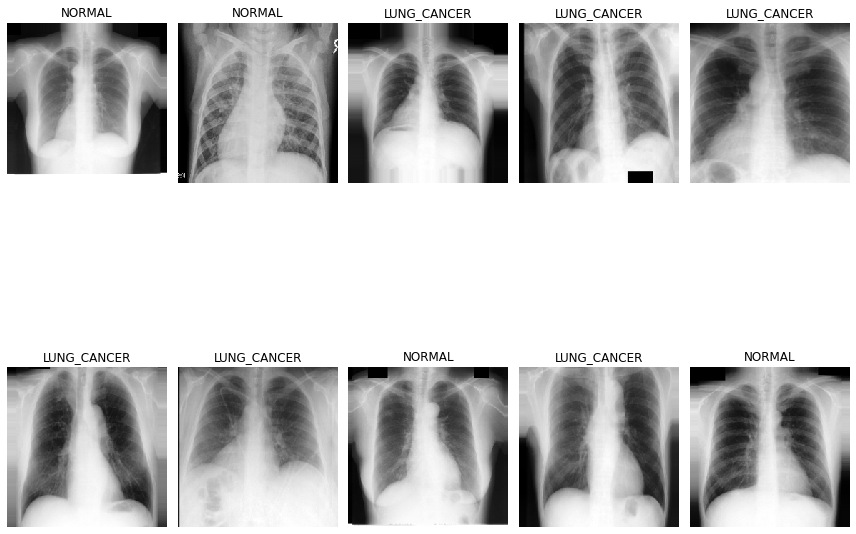

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        #print(X_batch)
        #print(Y_batch)
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'LUNG_CANCER'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

<p>Well, I can’t tell just by looking at these pictures which one is a case of pneumonia and which one is a normal case. For that, I would need a bachelor’s degree in radiology that takes from two to four years. Well, do not worry, you can teach a computer to tell the difference between them as a data science practitioner. We can hopefully achieve great accuracy in it or else the degree of radiologist it is.
</p>

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [7]:
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [8]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       7

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [55]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [56]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 0.8373015873015873, 1: 1.2411764705882353}


In [57]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
27/27 [==============================] - 56s 2s/step - loss: 0.6969 - accuracy: 0.4487 - val_loss: 0.6927 - val_accuracy: 0.6462
Epoch 2/25
27/27 [==============================] - 62s 2s/step - loss: 0.7065 - accuracy: 0.4226 - val_loss: 0.6935 - val_accuracy: 0.3538
Epoch 3/25
27/27 [==============================] - 58s 2s/step - loss: 0.6903 - accuracy: 0.4856 - val_loss: 0.6915 - val_accuracy: 0.6462
Epoch 4/25
27/27 [==============================] - 53s 2s/step - loss: 0.6870 - accuracy: 0.6179 - val_loss: 0.6925 - val_accuracy: 0.6615
Epoch 5/25
27/27 [==============================] - 57s 2s/step - loss: 0.6909 - accuracy: 0.5094 - val_loss: 0.6930 - val_accuracy: 0.6308

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
Epoch 6/25
27/27 [==============================] - 55s 2s/step - loss: 0.6992 - accuracy: 0.5879 - val_loss: 0.6931 - val_accuracy: 0.6000


In [35]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

3/3 [==============================] - 3s 770ms/step - loss: 0.6535 - accuracy: 0.8095
The testing accuracy is : 80.95238208770752 %


In [36]:
preds = cnn.predict(test,verbose=1)

3/3 [==============================] - 3s 702ms/step


In [37]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<AxesSubplot:>

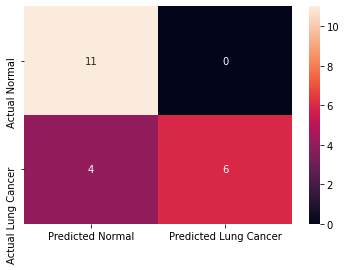

In [38]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Lung Cancer"],
columns=["Predicted Normal", "Predicted Lung Cancer"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [39]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','CANCER']))

              precision    recall  f1-score   support

      NORMAL       0.73      1.00      0.85        11
      CANCER       1.00      0.60      0.75        10

    accuracy                           0.81        21
   macro avg       0.87      0.80      0.80        21
weighted avg       0.86      0.81      0.80        21



In [41]:
# serialize the model to disk
print("[INFO] saving Cancer detector model...")
cnn.save("cancer_model_adam.h5", save_format="h5")

[INFO] saving Cancer detector model...


In [64]:
for layer in cnn.layers:
    print(layer)

In [74]:
for idx in range(len(cnn.layers)):
  print(cnn.get_layer(index = idx).name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
average_pooling2d
flatten
dense
dropout
dense_1


In [71]:
def loadModel():
    # with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    #     model = load_model('covid19_model3.h5' )#, compile=False)
    model = load_model('lung_cancer_model.h5')
    print("Model Loaded Succesfully")
    #print(model.summary())
    return model

In [73]:
from tensorflow.keras.models import load_model
cnn = loadModel()

Model Loaded Succesfully
